In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
import glob
import skimage.io
from skimage.feature import hog
import skimage.transform
import cv2
import pickle
import collections
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from tqdm import tqdm
from scipy.stats import zscore
from scipy.special import softmax
import base64
from io import BytesIO
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import exposure
from sklearn.preprocessing import StandardScaler

sns.set_style(style='whitegrid')

In [2]:
from matplotlib.style import available
print(available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [3]:
plt.style.use('ggplot')
# plt.style.use('seaborn-v0_8-white')

plt.rcParams.update({
    'figure.figsize': (10,6),
    'figure.dpi': 100,
    'axes.facecolor': 'white',
    'grid.color': 'lightgray',
    'axes.edgecolor': 'lightgray',
    'axes.titleweight': 'bold',
    'axes.titlesize': 16,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

In [4]:
IMG_DIR = '/home/georgetz/Desktop/Classes/Fall 2024/CSC 381 - Intro to Digital Image Processing/Final Project/Image'

In [5]:
def load_image_paths(folder_dir):
    all_paths = []
    class_labels = []
    for class_folder in os.listdir(folder_dir):
        class_path = os.path.join(folder_dir, class_folder)
        if os.path.isdir(class_path):
            # Gather all image paths for the class
            image_paths = glob.glob(f'{class_path}/*.jpg')
            all_paths.extend(image_paths)
            class_labels.extend([class_folder.split('Head')[0]] * len(image_paths))
    return all_paths, class_labels

In [6]:
def load_images(image_paths):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is not None:  
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            images.append(img)
        else:
            print(f"Warning: Failed to load image {path}")
    return images

In [7]:
# Load train and test image paths
image_paths, image_labels = load_image_paths(IMG_DIR)

print(f"# images: {len(image_paths)}")

# images: 2374


In [8]:
image_files = load_images(image_paths)

In [9]:
def create_data_dict(images, labels):
    data = {
        'data': images,    # Paths instead of arrays to save memory
        'target': labels,       # Corresponding labels
        'labels': list(set(labels))  # Unique labels (classes)
    }
    return data

In [10]:
image_data = create_data_dict(image_files, image_labels)

In [11]:
with open('images_data.pkl', 'wb') as f:
    pickle.dump(image_data, f)
    
print("Data has been saved to pickle files.")

Data has been saved to pickle files.


In [12]:
count_values = collections.Counter(image_data['target'])
df_counts = pd.DataFrame.from_dict(count_values, orient='index').reset_index()
df_counts.columns = ['Label', 'Count']
df_counts = df_counts.sort_values(by='Count', ascending=False)
df_counts

,Label,Count
6,Dog,389
8,Cat,159
5,Panda,116
10,Tiger,112
12,Duck,102
17,Bear,101
16,Cow,101
13,Deer,101
0,Pig,101
9,Wolf,100


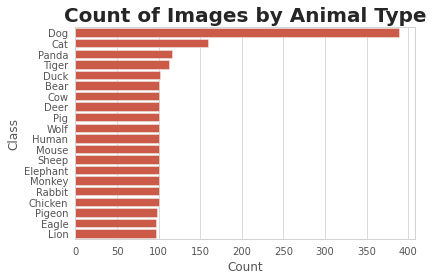

In [13]:
fig, ax = plt.subplots()
sns.barplot(x='Count', y='Label', data=df_counts)
ax.set_title('Count of Images by Animal Type', fontsize=20)
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Class', fontsize=12)
fig.tight_layout()
# fig.savefig('class_count.png')
plt.show()

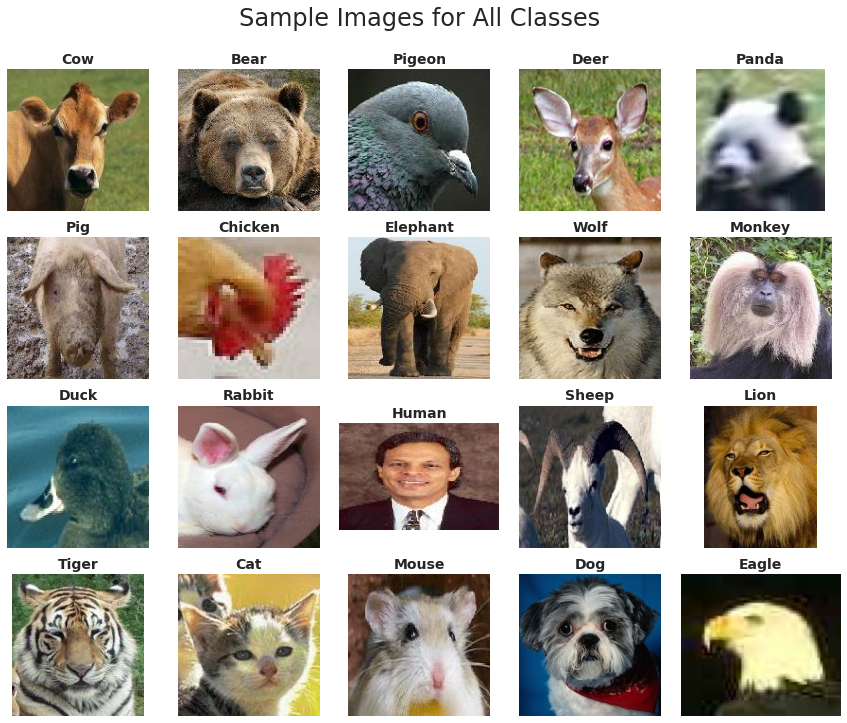

In [27]:
fig = plt.figure(figsize=(12,10))

for i,c in enumerate(image_data['labels']):
    index = image_data['target'].index(c)
    img = image_data['data'][index]
    # print(i, c)
    
    ax = plt.subplot(4,5,i+1)
    ax.imshow(img)
    ax.set_axis_off()
    plt.title(c, fontsize=14)
fig.suptitle('Sample Images for All Classes', fontsize=24, y=1)
fig.tight_layout()
# fig.savefig('image_samples.png')
plt.show()

In [15]:
# Define preprocessing functions
def preprocess_grayscale_resize(img, size=(128, 128)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, size, interpolation=cv2.INTER_LINEAR)
    return resized

def preprocess_hist_equalization(img, size=(128, 128)):
    resized = preprocess_grayscale_resize(img, size)
    equalized = cv2.equalizeHist(resized)
    return equalized

def preprocess_blur(img, size=(128, 128)):
    equalized = preprocess_hist_equalization(img, size)
    blurred = cv2.GaussianBlur(equalized, (3, 3), 0)
    return blurred

def preprocess_smooth(img, size=(128, 128)):
    blurred = preprocess_blur(img, size)
    smoothed = cv2.medianBlur(blurred, 3)
    return smoothed

# Dictionary of specified preprocessing methods
preprocessing_methods = {
    "Grayscale + Resize": preprocess_grayscale_resize,
    "Grayscale + Resize + HistEq": preprocess_hist_equalization,
    "Grayscale + Resize + HistEq + Blur": preprocess_blur,
    "Grayscale + Resize + HistEq + Blur + Smooth": preprocess_smooth
}

In [16]:
# split the data into independent and dependent
X = image_data['data'] # independent
y = image_data['target'] # dependent
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y)

In [17]:
def extract_hog_features(image, return_plot=False):
    # Extract HOG features and the HOG image (useful for visualization)
    hog_features, hog_image = hog(
        image,
        orientations=9,                 # Number of orientation bins
        pixels_per_cell=(8, 8),         # Size of the cell (in pixels)
        cells_per_block=(2, 2),         # Number of cells per block
        block_norm='L2-Hys',            # Block normalization method
        visualize=True,                 # Return the HOG image for visualization
        transform_sqrt=True,            # Apply power law compression (optional)
        feature_vector=True             # Return a 1D array (True for training)
    )
    if return_plot:
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        return hog_image_rescaled
    return hog_features, hog_image

# Example of applying HOG on a preprocessed grayscale image
sample_image = image_data['data'][0]
gray_img = preprocess_grayscale_resize(sample_image)
hog_features, hog_image = extract_hog_features(gray_img)

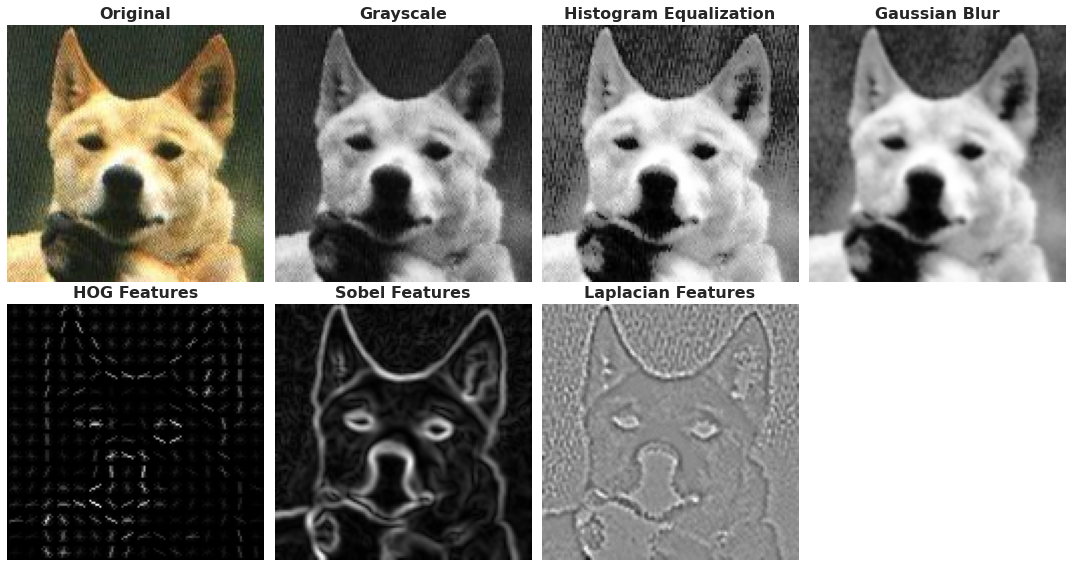

In [18]:
def plot_sobel_edges(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    sobel_combined = cv2.magnitude(sobel_x, sobel_y)
    return sobel_combined

# Laplacian visualization
def plot_laplacian_edges(image):
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    return laplacian

tmp = image_files[800]
tmp_gray = preprocess_grayscale_resize(tmp)
tmp_histeq = preprocess_hist_equalization(tmp)
tmp_blur = preprocess_blur(tmp)
tmp_blur_hog = extract_hog_features(tmp_blur)[1]
tmp_blur_sobel = plot_sobel_edges(tmp_blur)
tmp_blur_laplace = plot_laplacian_edges(tmp_blur)

titles = ['Original', 'Grayscale', 'Histogram Equalization', 'Gaussian Blur', 'HOG Features', 'Sobel Features', 'Laplacian Features']

fig, ax = plt.subplots(2,4,figsize=(15,8))
for i, (axi, imgi, titlei) in enumerate(zip(ax.ravel(), [tmp, tmp_gray, tmp_histeq, tmp_blur, tmp_blur_hog, tmp_blur_sobel, tmp_blur_laplace], titles)):
    if i == 0:
        axi.imshow(imgi)
    else:
        axi.imshow(imgi, cmap='gray')
    axi.set_axis_off()
    axi.set_title(titlei)
ax[1,3].axis('off')
    
fig.tight_layout()
fig.savefig('image_processing.png')
plt.show()

In [19]:
def extract_hog_features_batch(images):
    hog_features_list = []
    for img in images:
        features, _ = extract_hog_features(img)
        hog_features_list.append(features)
    return np.array(hog_features_list)

In [20]:
def extract_sobel_features(img):
    # Compute the Sobel gradient in the x and y directions
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute the gradient magnitude and direction
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    gradient_direction = np.arctan2(sobel_y, sobel_x)
    
    # Flatten the magnitude and direction for feature extraction
    features = np.hstack((gradient_magnitude.flatten(), gradient_direction.flatten()))
    
    return features

# Function to extract Sobel features for a batch of images
def extract_sobel_features_batch(images):
    sobel_features_list = []
    for img in images:
        features = extract_sobel_features(img)
        sobel_features_list.append(features)
    return np.array(sobel_features_list)

In [21]:
def extract_laplacian_features(img):
    # Compute the Laplacian of the image
    laplacian = cv2.Laplacian(img, cv2.CV_64F, ksize=3)
    
    # Flatten the Laplacian for feature extraction
    # features = laplacian.flatten()
    
    # Get absolute values to capture edge strength
    abs_laplacian = np.abs(laplacian)
    
    # Create feature vectors
    # Basic statistics of Laplacian response
    mean_response = np.mean(abs_laplacian)
    std_response = np.std(abs_laplacian)
    max_response = np.max(abs_laplacian)
    
    # Divide image into 4x4 grid and compute local statistics
    grid_features = []
    h, w = abs_laplacian.shape
    grid_h, grid_w = h // 4, w // 4
    
    for i in range(4):
        for j in range(4):
            cell = abs_laplacian[i*grid_h:(i+1)*grid_h, j*grid_w:(j+1)*grid_w]
            cell_stats = [
                np.mean(cell),
                np.std(cell),
                np.max(cell),
                np.percentile(cell, 75)
            ]
            grid_features.extend(cell_stats)
    
    # Compute histogram of Laplacian responses
    hist, _ = np.histogram(abs_laplacian, bins=32, range=(0, np.percentile(abs_laplacian, 99)))
    hist = hist / hist.sum()  # Normalize histogram
    
    # Combine all features
    features = np.concatenate([
        [mean_response, std_response, max_response],
        grid_features,
        hist
    ])
    
    return features
    

# Function to extract Laplacian features for a batch of images
def extract_laplacian_features_batch(images):
    laplacian_features_list = []
    for img in images:
        features = extract_laplacian_features(img)
        laplacian_features_list.append(features)
    return np.array(laplacian_features_list)

In [22]:
class ImageClassifierEvaluator:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
        self.confusion_matrices = {}  # Dictionary to store confusion matrices for each model

    def train_and_evaluate(self, model, model_name):
        # Train the model
        model.fit(self.X_train, self.y_train)
        
        # Predict on the test set
        y_pred = model.predict(self.X_test)
        
        # Calculate performance metrics
        accuracy = accuracy_score(self.y_test, y_pred)
        report = classification_report(self.y_test, y_pred, output_dict=True)
        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']
        f1_score = report['weighted avg']['f1-score']
        
        self.confusion_matrices[model_name] = confusion_matrix(self.y_test, y_pred)
        
        # Print confusion matrix
        # print(f"Confusion Matrix for {model_name}:\n", confusion_matrix(self.y_test, y_pred))
        
        # Store results in the DataFrame
        self.results = pd.concat([self.results, pd.DataFrame([{
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1_score
        }])], ignore_index=True)

    def get_results(self):
        return self.results
    
    def get_confusion_matrix(self, model_name):
        return self.confusion_matrices.get(model_name, "Model not found")

In [23]:
X_train_blur = [preprocess_blur(img) for img in X_train]
X_test_blur = [preprocess_blur(img) for img in X_test]


In [24]:
X_train_sobel = extract_sobel_features_batch(X_train_blur)
X_test_sobel = extract_sobel_features_batch(X_test_blur)
sobel_model = SVC(kernel='linear')
sobel_model.fit(X_train_sobel,  y_train)
y_pred_sobel = sobel_model.predict(X_test_sobel)

In [26]:
pd.DataFrame(classification_report(y_test, y_pred_sobel, output_dict=True)).T

,precision,recall,f1-score,support
Bear,0.428571,0.450000,0.439024,20.000000
Cat,0.580645,0.562500,0.571429,32.000000
Chicken,0.500000,0.400000,0.444444,20.000000
Cow,0.562500,0.450000,0.500000,20.000000
Deer,0.750000,0.600000,0.666667,20.000000
Dog,0.426357,0.705128,0.531401,78.000000
Duck,0.909091,0.476190,0.625000,21.000000
Eagle,0.588235,0.526316,0.555556,19.000000
Elephant,0.615385,0.400000,0.484848,20.000000
Human,0.590909,0.650000,0.619048,20.000000


In [32]:
X_train_laplace = extract_laplacian_features_batch(X_train_blur)
X_test_laplace = extract_laplacian_features_batch(X_test_blur)
laplace_model = SVC(kernel='linear')
laplace_model.fit(X_train_laplace,  y_train)
y_pred_laplace = laplace_model.predict(X_test_laplace)

In [33]:
pd.DataFrame(classification_report(y_test, y_pred_laplace, output_dict=True)).T

,precision,recall,f1-score,support
Bear,0.350000,0.350000,0.350000,20.000000
Cat,0.421053,0.500000,0.457143,32.000000
Chicken,0.222222,0.300000,0.255319,20.000000
Cow,0.222222,0.200000,0.210526,20.000000
Deer,0.500000,0.450000,0.473684,20.000000
Dog,0.301471,0.525641,0.383178,78.000000
Duck,0.476190,0.476190,0.476190,21.000000
Eagle,0.315789,0.315789,0.315789,19.000000
Elephant,0.363636,0.400000,0.380952,20.000000
Human,0.722222,0.650000,0.684211,20.000000


In [24]:
X_train_hog = extract_hog_features_batch(X_train_blur)
X_test_hog = extract_hog_features_batch(X_test_blur)

In [25]:
scaler = StandardScaler()
X_train_hog_scaled = scaler.fit_transform(X_train_hog)
X_test_hog_scaled = scaler.transform(X_test_hog)

In [34]:
hog_model = SVC(kernel='linear')
hog_model.fit(X_train_hog, y_train)
y_pred_hog = hog_model.predict(X_test_hog)

In [35]:
pd.DataFrame(classification_report(y_test, y_pred_hog, output_dict=True)).T

,precision,recall,f1-score,support
Bear,0.809524,0.850000,0.829268,20.000000
Cat,0.684211,0.812500,0.742857,32.000000
Chicken,0.772727,0.850000,0.809524,20.000000
Cow,1.000000,0.550000,0.709677,20.000000
Deer,0.800000,1.000000,0.888889,20.000000
Dog,0.614679,0.858974,0.716578,78.000000
Duck,0.833333,0.714286,0.769231,21.000000
Eagle,0.666667,0.631579,0.648649,19.000000
Elephant,0.882353,0.750000,0.810811,20.000000
Human,1.000000,1.000000,1.000000,20.000000


In [32]:
evaluator = ImageClassifierEvaluator(X_train_hog, X_test_hog, y_train, y_test)

models = {
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Support Vector Machine': SVC(kernel='linear'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SGD Classifier': SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
}

In [33]:
for model_name, model in models.items():
    evaluator.train_and_evaluate(model, model_name)

/home/georgetz/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
evaluator.get_results()

,Model,Accuracy,Precision,Recall,F1-Score
0,K-Nearest Neighbors,0.385263,0.790773,0.385263,0.435957
1,Support Vector Machine,0.768421,0.784406,0.768421,0.769674
2,Random Forest,0.446316,0.685024,0.446316,0.430545
3,Logistic Regression,0.76,0.774758,0.76,0.759199
4,SGD Classifier,0.623158,0.758255,0.623158,0.652855


In [151]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'degree': [2, 3, 4]  # Only used if kernel='poly'
}

# Initialize the model
svc = SVC()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='f1_weighted', verbose=2)

# Fit the model
grid_search.fit(X_train_hog_scaled, y_train)  # Replace with your training data variables

# Print the best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=  13.3s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=  13.8s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=  13.8s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=  13.9s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=  13.5s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=  17.5s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=  17.9s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=  17.2s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=  17.8s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=  17.7s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=  17.8s
[CV] END ...........C=0.1, degree=2, gamma=sc

In [28]:
# with open('grid_search.pkl', 'wb') as file:
#     pickle.dump(grid_search, file)

# with open('grid_search_scaled.pkl', 'wb') as file:
#     pickle.dump(grid_search, file)

# with open('grid_search.pkl', 'rb') as file:
#     grid_search = pickle.load(file)

with open('grid_search_scaled.pkl', 'rb') as file:
    grid_search = pickle.load(file)

In [33]:
grid_search.best_score_

0.7531226213571733

In [34]:
grid_search.best_params_

{'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

In [29]:
final_model = grid_search.best_estimator_
final_model.fit(X_train_hog_scaled,  y_train)
y_pred = final_model.predict(X_test_hog_scaled)

In [140]:
tst = cv2.imread('/home/georgetz/Downloads/istockphoto-157671964-612x612.jpg')

In [156]:
# with open('scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

In [158]:
# with open('final_model.pkl', 'wb') as file:
#     pickle.dump(final_model, file)

In [106]:
decision_values = final_model.decision_function(X_test_hog[0].reshape(1,-1))

In [112]:
decision_values

array([[ 8.7496702 , 16.29884826, 13.28130158, 14.26921871, 18.30308638,
         9.80789487,  6.75311734, 12.21969002,  9.82143926, -0.29987884,
         0.69683313,  3.71446631, 15.29226659,  2.71303276, 17.29023138,
         4.74393908, 19.31057563,  7.75661585,  1.70258519,  6.73524307]])

In [120]:
tst = cv2.imread('/home/georgetz/Downloads/istockphoto-157671964-612x612.jpg')
tst = preprocess_blur(tst)
tst_hog, _ = extract_hog_features(tst)

In [119]:
hog(tst, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys')

array([0.07978843, 0.        , 0.        , ..., 0.10872578, 0.17867661,
       0.27566591])

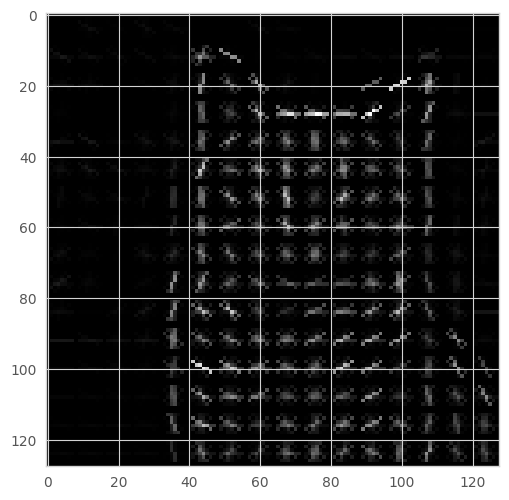

In [125]:
plt.imshow(_, cmap='gray')

In [193]:
pickle.dumps(final_model)

In [108]:
# cal. z score
z = zscore(decision_values.flatten())
prob_values = softmax(z)
prob_values

array([0.0280063 , 0.09906973, 0.059789  , 0.07053823, 0.13855172,
       0.03343252, 0.02005134, 0.05005666, 0.03350838, 0.00615916,
       0.00727719, 0.0120584 , 0.08371074, 0.01019775, 0.1169489 ,
       0.01432562, 0.16399768, 0.02371806, 0.00861119, 0.01999145])

In [105]:
prob_values.argsort()[::-1][:5]

array([16,  4, 14,  1, 12])

In [82]:
prob_values_sorted = prob_values.argsort(axis=1)[:,::-1]
prob_values_sorted

array([[ 4, 16, 14, ..., 11, 10,  5],
       [18, 11,  5, ...,  2,  7,  3],
       [ 4,  3, 17, ..., 13, 11,  5],
       ...,
       [ 8, 14, 12, ..., 17, 15, 16],
       [ 9, 15,  6, ..., 14, 12,  1],
       [ 4, 17, 14, ...,  6, 18, 11]])

In [153]:
def image_array_to_html(image_array):
    buffer = BytesIO()
    plt.imsave(buffer, image_array, format='jpeg')
    buffer.seek(0)
    b64_string = base64.b64encode(buffer.read()).decode('utf-8')
    return f'<img src="data:image/jpeg;base64,{b64_string}" width="100">'

,Image,Top 1,Top 2,Top 3,Top 4,Top 5
0,,Pigeon (21.89%),Duck (15.03%),Eagle (14.25%),Monkey (7.39%),Elephant (6.52%)
1,,Wolf (23.44%),Mouse (11.48%),Tiger (9.57%),Panda (8.85%),Bear (8.42%)
2,,Pigeon (16.40%),Eagle (12.22%),Panda (12.15%),Monkey (11.51%),Dog (9.30%)
3,,Panda (23.35%),Eagle (12.00%),Pigeon (9.76%),Monkey (9.25%),Tiger (9.14%)
4,,Cow (18.06%),Elephant (16.18%),Sheep (14.52%),Human (12.86%),Pig (7.07%)

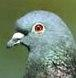
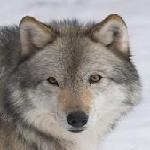
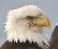
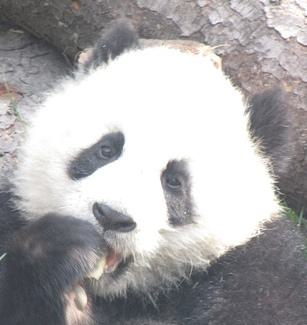
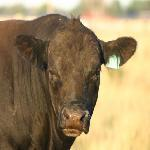

In [156]:
# Prepare data for the DataFrame
data = []
for i, probs in enumerate(prob_values[:5]):
    sorted_indices = np.argsort(probs)[::-1]  # Sort indices in descending order
    top_5_indices = sorted_indices[:5]
    # top_5_classes = [final_model.classes_[idx] for idx in top_5_indices]
    top_5_classes_with_probs = [
        f"{final_model.classes_[idx]} ({probs[idx]:.2%})" for idx in top_5_indices
    ]
    
    # Create a row with image and top 5 classes
    image_html = image_array_to_html(X_test[i])    
    row = [image_html] + top_5_classes_with_probs
    data.append(row)

# Create a DataFrame
columns = ['Image', 'Top 1', 'Top 2', 'Top 3', 'Top 4', 'Top 5']
df = pd.DataFrame(data, columns=columns)

# Display the DataFrame using IPython display
display(HTML(df.to_html(escape=False)))

In [31]:
import py7zr
file_parts = ['final_model.pkl.7z.001', 'final_model.pkl.7z.002']
combined_file_path = 'combined_final_model.7z'

with open(combined_file_path, 'wb') as combined_file:
    for part in file_parts:
        with open(part, 'rb') as f:
            combined_file.write(f.read())

In [32]:
extracted_folder = 'extracted_content'
with py7zr.SevenZipFile(combined_file_path, 'r') as archive:
    archive.extractall(path=extracted_folder)

In [33]:
pickle_file_path = f'{extracted_folder}/final_model.pkl'  # Adjust if file name differs
with open(pickle_file_path, 'rb') as pkl_file:
    model = pickle.load(pkl_file)

# The model is now loaded and can be used
print("Model loaded successfully!")

Model loaded successfully!


In [35]:
model.classes_

array(['Bear', 'Cat', 'Chicken', 'Cow', 'Deer', 'Dog', 'Duck', 'Eagle',
       'Elephant', 'Human', 'Lion', 'Monkey', 'Mouse', 'Panda', 'Pig',
       'Pigeon', 'Rabbit', 'Sheep', 'Tiger', 'Wolf'], dtype='<U8')